# 0. Import Libraries

In [1]:
import json
from collections import Counter
from roboflow import Roboflow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from collections import Counter, defaultdict

# 1. Download Dataset

In [2]:
! pip install roboflow

In [3]:
# TODO: Add your Roboflow API key
rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")

# Download the dice dataset
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dice-2 in coco:: 100%|██████████| 1467/1467 [00:01<00:00, 1191.36it/s]

Dataset downloaded to: c:\Users\Finn_\Downloads\dice-2


# 2. Load Annotation Files from the '/content/dice-2' directory.



In [6]:
#Define Base Dataset
# 1: Original Dataset 2: Annotation Based Balancing
base = 1

if base == 1:
  # Load the training annotation file
  with open(os.path.join(dataset.location, 'train/_annotations.coco.json')) as f:
      train_annotations = json.load(f)
  print("Training annotations loaded.")

  # Load the validation annotation file
  with open(os.path.join(dataset.location, 'valid/_annotations.coco.json')) as f:
      val_annotations = json.load(f)
  print("Validation annotations loaded.")

  # Load the test annotation file
  with open(os.path.join(dataset.location, 'test/_annotations.coco.json')) as f:
      test_annotations = json.load(f)
  print("Test annotations loaded.")

elif base == 2:
  # Define the paths to the balanced annotation files
  val_balanced_path = '/content/dice-2/balanced_annotations/val_balanced.coco.json'
  train_balanced_path = '/content/dice-2/balanced_annotations/train_balanced.coco.json'
  test_balanced_path = '/content/dice-2/balanced_annotations/test_balanced.coco.json'

  # Load the balanced validation annotation file
  with open('/content/dice-2/balanced_annotations/val_balanced.coco.json') as f:
      val_annotations = json.load(f)
  print(f"Balanced validation annotations loaded from: {val_balanced_path}")

  # Load the balanced train annotation file
  with open('/content/dice-2/balanced_annotations/train_balanced.coco.json') as f:
      train_annotations = json.load(f)
  print(f"Balanced train annotations loaded from: {train_balanced_path}")

    # Load the balanced test annotation file
  with open('/content/dice-2/balanced_annotations/test_balanced.coco.json') as f:
      test_annotations = json.load(f)
  print(f"Balanced test annotations loaded from: {test_balanced_path}")

Training annotations loaded.
Validation annotations loaded.
Test annotations loaded.


In [7]:
def create_detailed_class_mapping(annotations):
    """
    Creates a detailed mapping for classes including total annotation counts, images per class,
    and annotation counts per class within each image.

    Args:
        annotations (dict): A dictionary containing COCO-format annotations.

    Returns:
        tuple: A tuple containing:
            - total_annotations_per_class (dict): Total annotation count for each class.
            - images_per_class (dict): Keys are class names, values are sets of image IDs.
            - annotations_per_class_per_image (dict): Keys are class names, values are dicts where
                                                    keys are image IDs and values are annotation counts.
    """
    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

    total_annotations_per_class = Counter()
    images_per_class = defaultdict(set)
    annotations_per_class_per_image = defaultdict(lambda: defaultdict(int))

    for ann in annotations['annotations']:
        category_id = ann['category_id']
        image_id = ann['image_id']
        category_name = category_id_to_name.get(category_id, 'unknown')

        # Update total annotations per class
        total_annotations_per_class[category_name] += 1

        # Add image ID to the set for the current class
        images_per_class[category_name].add(image_id)

        # Increment the count for the current class within the current image
        annotations_per_class_per_image[category_name][image_id] += 1

    # Convert Counter and defaultdict to regular dicts for output
    return dict(total_annotations_per_class), {k: list(v) for k,v in images_per_class.items()}, {k: dict(v) for k,v in annotations_per_class_per_image.items()}

# Apply the function to each dataset
train_total_ann, train_images_per_class, train_ann_per_img = create_detailed_class_mapping(train_annotations)
val_total_ann, val_images_per_class, val_ann_per_img = create_detailed_class_mapping(val_annotations)
test_total_ann, test_images_per_class, test_ann_per_img = create_detailed_class_mapping(test_annotations)


# 3. Calculate and Show Class Distribution



In [34]:
# Function to calculate distribution
def get_class_distribution(annotations):

    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}
    class_counts = Counter()

    for ann in annotations['annotations']:
        category_id = ann['category_id']
        category_name = category_id_to_name.get(category_id, 'unknown')
        class_counts[category_name] += 1

    return dict(class_counts)

# Calculate class distribution for each set
train_class_distribution = get_class_distribution(train_annotations)
val_class_distribution = get_class_distribution(val_annotations)
test_class_distribution = get_class_distribution(test_annotations)

print("Training Class Distribution:", train_class_distribution)
print("Validation Class Distribution:", val_class_distribution)
print("Test Class Distribution:", test_class_distribution)


Training Class Distribution: {'4': 427, '3': 427, '6': 427, '2': 427, '1': 427, '5': 427}
Validation Class Distribution: {'2': 59, '1': 59, '5': 59, '6': 59, '4': 59, '3': 59}
Test Class Distribution: {'3': 25, '2': 25, '5': 25, '1': 25, '4': 25, '6': 25}


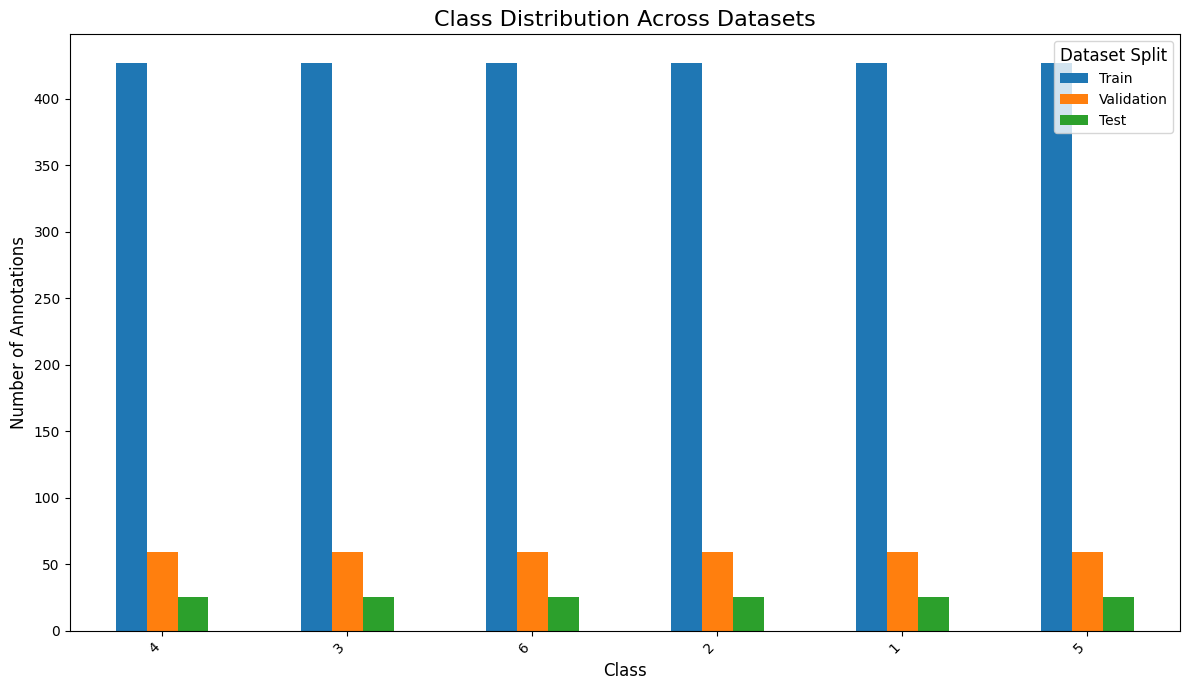

Class distribution plot displayed.


In [35]:
# Combine the class distribution dictionaries into a single DataFrame
data = {
    'Train': train_class_distribution,
    'Validation': val_class_distribution,
    'Test': test_class_distribution
}
df_distribution = pd.DataFrame(data).fillna(0) # Fill any missing class counts with 0

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))
df_distribution.plot.bar(ax=ax)

# Add title and labels
plt.title('Class Distribution Across Datasets', fontsize=16)
plt.ylabel('Number of Annotations', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
plt.legend(title='Dataset Split', fontsize=10, title_fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print("Class distribution plot displayed.")

## 4. Determine Target Counts


## 4.1 For Balancing

In [13]:
# 1. For the training set, find the minimum value among the class counts
train_target_count = np.min(list(train_class_distribution.values()))

# 2. For the validation set, find the minimum value among the class counts
val_target_count = np.min(list(val_class_distribution.values()))

# 3. For the test set, find the minimum value among the class counts
test_target_count = np.min(list(test_class_distribution.values()))

# 4. Print the calculated target counts
print(f"Target count for a balanced Training set: {train_target_count}")
print(f"Target count for a balanced Validation set: {val_target_count}")
print(f"Target count for a balanced Test set: {test_target_count}")

Target count for a balanced Training set: 427
Target count for a balanced Validation set: 59
Target count for a balanced Test set: 25


## 4.2 For Imbalancing

In [ ]:
# Define Zipfian target counts for Validation Set
# Current max count for any class is 59 (from current_val_class_distribution)
zipfian_val_target_counts = {
    '6': 59, # Highest
    '5': 30,
    '4': 20,
    '3': 15,
    '2': 12,
    '1': 10  # Lowest
}

# Define Zipfian target counts for Train Set
# Current max count for any class is 25 (from current_train_class_distribution)
zipfian_train_target_counts = {
    '6': 427, # Highest
    '5': 214,
    '4': 142,
    '3': 107,
    '2': 85,
    '1': 71  # Lowest
}

print("Zipfian Validation Target Counts:", zipfian_val_target_counts)
print("Zipfian Train Target Counts:", zipfian_train_target_counts)

Zipfian Validation Target Counts: {'6': 59, '5': 30, '4': 20, '3': 15, '2': 12, '1': 10}
Zipfian Train Target Counts: {'6': 427, '5': 214, '4': 142, '3': 107, '2': 85, '1': 71}


# 5. Functions to change the Dataset



## 5.1 Annotation Based Balancing


In [16]:
def balance_annotations(annotations, target_count, class_distribution):
    """
    Balances COCO-format annotations by undersampling classes that exceed the target count.

    Args:
        annotations (dict): A dictionary containing COCO-format annotations.
        target_count (int): The desired number of annotations per class.
        class_distribution (dict): The current class counts for each class.

    Returns:
        dict: The modified annotations dictionary with balanced classes.
    """
    balanced_annotations_list = []

    # Group annotations by category_id
    annotations_by_category = {cat['id']: [] for cat in annotations['categories']}
    for ann in annotations['annotations']:
        annotations_by_category[ann['category_id']].append(ann)

    # Get category name to ID mapping for easier lookup using class_distribution
    category_name_to_id = {cat['name']: cat['id'] for cat in annotations['categories']}

    for category_name, current_count in class_distribution.items():
        category_id = category_name_to_id.get(category_name)
        if category_id is None: # Should not happen if class_distribution is derived from annotations
            continue

        current_category_annotations = annotations_by_category[category_id]

        if current_count > target_count:
            # Randomly sample 'target_count' annotations for this category
            sampled_annotations = random.sample(current_category_annotations, target_count)
            balanced_annotations_list.extend(sampled_annotations)
        else:
            # If count is less than or equal to target, keep all annotations for this category
            balanced_annotations_list.extend(current_category_annotations)

    # Update the 'annotations' key with the balanced list
    annotations['annotations'] = balanced_annotations_list

    return annotations

# Balance the training set
train_annotations = balance_annotations(train_annotations, train_target_count, train_class_distribution)

print("Training set has been balanced to the target count.")

Training set has been balanced to the target count.


## 5.2 Annotation Based Imbalancing

In [38]:
def balance_annotations_with_zipfian_targets(annotations, zipfian_target_counts_dict):
    """
    Balances COCO-format annotations by undersampling classes based on specified Zipfian target counts.

    Args:
        annotations (dict): A dictionary containing COCO-format annotations.
        zipfian_target_counts_dict (dict): A dictionary where keys are class names and values are their target counts.

    Returns:
        dict: The modified annotations dictionary with Zipfian-balanced classes.
    """
    balanced_annotations_list = []

    # Group annotations by category_id
    annotations_by_category = {cat['id']: [] for cat in annotations['categories']}
    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

    for ann in annotations['annotations']:
        annotations_by_category[ann['category_id']].append(ann)

    for category_id, ann_list in annotations_by_category.items():
        category_name = category_id_to_name.get(category_id)
        if category_name is None:
            continue

        target_count = zipfian_target_counts_dict.get(category_name, 0) # Get specific target for this class

        if len(ann_list) > target_count:
            # Randomly sample 'target_count' annotations for this category
            sampled_annotations = random.sample(ann_list, target_count)
            balanced_annotations_list.extend(sampled_annotations)
        else:
            # If count is less than or equal to target, keep all annotations for this category
            balanced_annotations_list.extend(ann_list)

    # Update the 'annotations' key with the balanced list
    annotations['annotations'] = balanced_annotations_list

    return annotations

Validation set has been Zipfian-balanced.
Test set has been Zipfian-balanced.


# 5.3 Image Based Balancing

In [ ]:
def create_detailed_class_mapping(annotations):
    """
    Creates a detailed mapping for classes including total annotation counts, images per class,
    and annotation counts per class within each image.

    Args:
        annotations (dict): A dictionary containing COCO-format annotations.

    Returns:
        tuple: A tuple containing:
            - total_annotations_per_class (dict): Total annotation count for each class.
            - images_per_class (dict): Keys are class names, values are sets of image IDs.
            - annotations_per_class_per_image (dict): Keys are class names, values are dicts where
                                                    keys are image IDs and values are annotation counts.
    """
    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

    total_annotations_per_class = Counter()
    images_per_class = defaultdict(set)
    annotations_per_class_per_image = defaultdict(lambda: defaultdict(int))

    for ann in annotations['annotations']:
        category_id = ann['category_id']
        image_id = ann['image_id']
        category_name = category_id_to_name.get(category_id, 'unknown')

        # Update total annotations per class
        total_annotations_per_class[category_name] += 1

        # Add image ID to the set for the current class
        images_per_class[category_name].add(image_id)

        # Increment the count for the current class within the current image
        annotations_per_class_per_image[category_name][image_id] += 1

    # Convert Counter and defaultdict to regular dicts for output
    return dict(total_annotations_per_class), {k: list(v) for k,v in images_per_class.items()}, {k: dict(v) for k,v in annotations_per_class_per_image.items()}

# Apply the function to each dataset
train_total_ann, train_images_per_class, train_ann_per_img = create_detailed_class_mapping(train_annotations)
val_total_ann, val_images_per_class, val_ann_per_img = create_detailed_class_mapping(val_annotations)
test_total_ann, test_images_per_class, test_ann_per_img = create_detailed_class_mapping(test_annotations)


In [ ]:
import random
from collections import defaultdict, Counter

def balance_by_image_object_count(annotations, annotations_per_class_per_image, target_annotation_count):
    """
    Implements a sophisticated greedy image selection strategy to balance class distributions
    by object counts within images.

    Args:
        annotations (dict): The original COCO-format annotations dictionary.
        annotations_per_class_per_image (dict): Mapping of class_name -> image_id -> annotation_count.
        target_annotation_count (int): The predetermined target annotation count for each class.

    Returns:
        dict: The new annotations dictionary with images selected for object-count balancing.
    """
    kept_image_ids = set()
    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}
    class_names = [cat['name'] for cat in annotations['categories']]

    # Initialize current counts for all classes to 0
    current_class_counts = Counter({name: 0 for name in class_names})

    # Get all unique image IDs from the original annotations
    all_image_ids_set = {img['id'] for img in annotations['images']}

    # Create image_to_class_ann_counts from annotations_per_class_per_image for efficient lookup
    image_to_class_ann_counts = defaultdict(Counter)
    for class_name, img_counts in annotations_per_class_per_image.items():
        for image_id, count in img_counts.items():
            image_to_class_ann_counts[image_id][class_name] += count

    # Keep a pool of available images to select from
    available_image_pool = set(all_image_ids_set)

    # Flag to track if any progress was made in an iteration to avoid infinite loops
    made_progress = True

    while made_progress and available_image_pool:
        made_progress = False # Reset for the current iteration

        # Check if all classes have reached or exceeded the target
        all_classes_balanced = True
        for class_name in class_names:
            if current_class_counts[class_name] < target_annotation_count:
                all_classes_balanced = False
                break
        if all_classes_balanced:
            break # All classes are balanced, break the main loop

        best_image_id_this_iteration = None
        max_score = -float('inf') # Initialize with a very low score to ensure any valid image is selected

        # Shuffle the available image pool to introduce randomness and break ties fairly
        shuffled_available_images = list(available_image_pool)
        random.shuffle(shuffled_available_images)

        # Iterate through available images to find the one with the best score
        for candidate_image_id in shuffled_available_images:
            temp_score = 0
            # Get annotation counts for classes within the current candidate image
            class_ann_counts_in_candidate_image = image_to_class_ann_counts.get(candidate_image_id, Counter())

            for class_name, ann_count_in_image in class_ann_counts_in_candidate_image.items():
                if current_class_counts[class_name] < target_annotation_count:
                    # Prioritize images that contribute to classes still below target
                    # Higher weight for classes further from target, ensuring they get attention
                    temp_score += ann_count_in_image * (target_annotation_count - current_class_counts[class_name])
                else:
                    # Slightly penalize for contributing to classes already at or above target
                    # This discourages selection of images that only add to existing surpluses
                    temp_score -= ann_count_in_image

            # Select the image that yields the highest (most beneficial) score
            if temp_score > max_score:
                max_score = temp_score
                best_image_id_this_iteration = candidate_image_id

        # If no image was found that has a positive score (meaning no image can improve the balance significantly),
        # or if all available images have been considered and none provided a sufficiently good score, break.
        if best_image_id_this_iteration is None or max_score <= 0:
            break

        # Add the best image to the kept set
        kept_image_ids.add(best_image_id_this_iteration)
        available_image_pool.remove(best_image_id_this_iteration)
        made_progress = True # Mark that an image was successfully added

        # Update current class counts based on the newly selected image
        class_ann_counts_in_selected_image = image_to_class_ann_counts.get(best_image_id_this_iteration, Counter())
        for class_name, ann_count in class_ann_counts_in_selected_image.items():
            current_class_counts[class_name] += ann_count

    # Construct the new COCO-format annotations dictionary with only the selected images and their annotations
    balanced_annotations = {
        'info': annotations['info'],
        'licenses': annotations['licenses'],
        'categories': annotations['categories'],
        'images': [],
        'annotations': []
    }

    original_images_dict = {img['id']: img for img in annotations['images']}
    for img_id in sorted(list(kept_image_ids)): # Sort image IDs for deterministic output
        if img_id in original_images_dict:
            balanced_annotations['images'].append(original_images_dict[img_id])

    # Include only annotations belonging to the kept images
    for ann in annotations['annotations']:
        if ann['image_id'] in kept_image_ids:
            balanced_annotations['annotations'].append(ann)

    return balanced_annotations

print("Defined function 'balance_annotations_by_object_count_optimized'.")

Defined function 'balance_annotations_by_object_count_optimized'.


## 5.4 Image based imbalancing

In [ ]:
def balance_by_image_object_count_zipfian(annotations, annotations_per_class_per_image, target_annotation_counts_dict):
    """
    Implements a sophisticated greedy image selection strategy to balance class distributions
    by object counts within images, using class-specific Zipfian target counts.

    Args:
        annotations (dict): The original COCO-format annotations dictionary.
        annotations_per_class_per_image (dict): Mapping of class_name -> image_id -> annotation_count.
        target_annotation_counts_dict (dict): A dictionary where keys are class names and values are their target counts.

    Returns:
        dict: The new annotations dictionary with images selected for object-count balancing.
    """
    kept_image_ids = set()
    category_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}
    class_names = [cat['name'] for cat in annotations['categories']]

    # Initialize current counts for all classes to 0
    current_class_counts = Counter({name: 0 for name in class_names})

    # Get all unique image IDs from the original annotations
    all_image_ids_set = {img['id'] for img in annotations['images']}

    # Create image_to_class_ann_counts from annotations_per_class_per_image for efficient lookup
    image_to_class_ann_counts = defaultdict(Counter)
    for class_name, img_counts in annotations_per_class_per_image.items():
        for image_id, count in img_counts.items():
            image_to_class_ann_counts[image_id][class_name] += count

    # Keep a pool of available images to select from
    available_image_pool = set(all_image_ids_set)

    # Flag to track if any progress was made in an iteration to avoid infinite loops
    made_progress = True

    while made_progress and available_image_pool:
        made_progress = False # Reset for the current iteration

        # Check if all classes have reached or exceeded their specific target
        all_classes_balanced = True
        for class_name in class_names:
            target_count = target_annotation_counts_dict.get(class_name, 0)
            if current_class_counts[class_name] < target_count:
                all_classes_balanced = False
                break
        if all_classes_balanced:
            break # All classes are balanced according to their specific targets, break the main loop

        best_image_id_this_iteration = None
        max_score = -float('inf') # Initialize with a very low score to ensure any valid image is selected

        # Shuffle the available image pool to introduce randomness and break ties fairly
        shuffled_available_images = list(available_image_pool)
        random.shuffle(shuffled_available_images)

        # Iterate through available images to find the one with the best score
        for candidate_image_id in shuffled_available_images:
            temp_score = 0
            # Get annotation counts for classes within the current candidate image
            class_ann_counts_in_candidate_image = image_to_class_ann_counts.get(candidate_image_id, Counter())

            for class_name, ann_count_in_image in class_ann_counts_in_candidate_image.items():
                target_count = target_annotation_counts_dict.get(class_name, 0)
                if current_class_counts[class_name] < target_count:
                    # Prioritize images that contribute to classes still below target
                    # Higher weight for classes further from target, ensuring they get attention
                    temp_score += ann_count_in_image * (target_count - current_class_counts[class_name])
                else:
                    # Slightly penalize for contributing to classes already at or above target
                    # This discourages selection of images that only add to existing surpluses
                    temp_score -= ann_count_in_image

            # Select the image that yields the highest (most beneficial) score
            if temp_score > max_score:
                max_score = temp_score
                best_image_id_this_iteration = candidate_image_id

        # If no image was found that has a positive score (meaning no image can improve the balance significantly),
        # or if all available images have been considered and none provided a sufficiently good score, break.
        if best_image_id_this_iteration is None or max_score <= 0:
            break

        # Add the best image to the kept set
        kept_image_ids.add(best_image_id_this_iteration)
        available_image_pool.remove(best_image_id_this_iteration)
        made_progress = True # Mark that an image was successfully added

        # Update current class counts based on the newly selected image
        class_ann_counts_in_selected_image = image_to_class_ann_counts.get(best_image_id_this_iteration, Counter())
        for class_name, ann_count in class_ann_counts_in_selected_image.items():
            current_class_counts[class_name] += ann_count

    # Construct the new COCO-format annotations dictionary with only the selected images and their annotations
    balanced_annotations = {
        'info': annotations['info'],
        'licenses': annotations['licenses'],
        'categories': annotations['categories'],
        'images': [],
        'annotations': []
    }

    original_images_dict = {img['id']: img for img in annotations['images']}
    for img_id in sorted(list(kept_image_ids)): # Sort image IDs for deterministic output
        if img_id in original_images_dict:
            balanced_annotations['images'].append(original_images_dict[img_id])

    # Include only annotations belonging to the kept images
    for ann in annotations['annotations']:
        if ann['image_id'] in kept_image_ids:
            balanced_annotations['annotations'].append(ann)

    return balanced_annotations

print("Defined function 'balance_annotations_by_object_count_zipfian'.")

# 6. Creation of Datasets

## 6.1 Creation of annotation based balancing

In [17]:
val_annotations = balance_annotations(val_annotations, val_target_count, val_class_distribution)
print("Validation set has been balanced to the target count.")

Validation set has been balanced to the target count.


In [18]:
test_annotations = balance_annotations(test_annotations, test_target_count, test_class_distribution)
print("Test set has been balanced to the target count.")

Test set has been balanced to the target count.


In [19]:
train_annotations = balance_annotations(train_annotations, train_target_count, train_class_distribution)
print("Train set has been balanced to the target count.")

Train set has been balanced to the target count.


## 6.2 Creation of annotation based imbalancing

In [ ]:
# Apply Zipfian balancing to the validation set
val_annotations = balance_annotations_with_zipfian_targets(zipfian_val_target_counts, zipfian_val_target_counts)
print("Validation set has been Zipfian-balanced.")

# Apply Zipfian balancing to the train set
train_annotations = balance_annotations_with_zipfian_targets(zipfian_train_target_counts, zipfian_train_target_counts)
print("Train set has been Zipfian-balanced.")

Validation set has been Zipfian-balanced.
Test set has been Zipfian-balanced.


## 6.3 Creation of image based balancing

In [ ]:
optimized_balanced_train_annotations = balance_by_image_object_count(train_annotations, train_ann_per_img, train_target_count)
print("Training set has been optimized-balanced by object count using selected images.")

optimized_balanced_val_annotations = balance_by_image_object_count(val_annotations, val_ann_per_img, val_target_count)
print("Validation set has been optimized-balanced by object count using selected images.")

optimized_balanced_test_annotations = balance_by_image_object_count(test_annotations, test_ann_per_img, test_target_count)
print("Test set has been optimized-balanced by object count using selected images.")

Training set has been optimized-balanced by object count using selected images.


## 6.4 Creation of image based imbalancing

In [ ]:
zipfian_object_balanced_train_annotations = balance_by_image_object_count_zipfian(train_annotations, train_ann_per_img, zipfian_train_target_counts)
print("Training set has been Zipfian object-count-balanced using selected images.")

zipfian_object_balanced_val_annotations = balance_by_image_object_count_zipfian(val_annotations, val_ann_per_img, zipfian_val_target_counts)
print("Validation set has been Zipfian object-count-balanced using selected images.")

# 7. Saving the Datasets

In [ ]:
# Define the directory for balanced annotations
output_dir = '/content/dice-2/zip_balanced_annotations' #Define name
os.makedirs(output_dir, exist_ok=True)

In [42]:
# Save the balanced training annotations
with open(os.path.join(output_dir, 'train.coco.json'), 'w') as f:
    json.dump(train_annotations, f, indent=4)
print(f"training annotations saved to: {os.path.join(output_dir, 'train.coco.json')}")

Balanced training annotations saved to: /content/dice-2/zip_balanced_annotations/train.coco.json


In [43]:
# Save the balanced validation annotations
with open(os.path.join(output_dir, 'val.coco.json'), 'w') as f:
    json.dump(val_annotations, f, indent=4)
print(f"validation annotations saved to: {os.path.join(output_dir, 'val.coco.json')}")

Balanced validation annotations saved to: /content/dice-2/zip_balanced_annotations/val.coco.json


In [44]:
# Save the balanced test annotations
with open(os.path.join(output_dir, 'test.coco.json'), 'w') as f:
    json.dump(test_annotations, f, indent=4)
print(f"test annotations saved to: {os.path.join(output_dir, 'test.coco.json')}")

Balanced test annotations saved to: /content/dice-2/zip_balanced_annotations/test.coco.json
